In [1]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

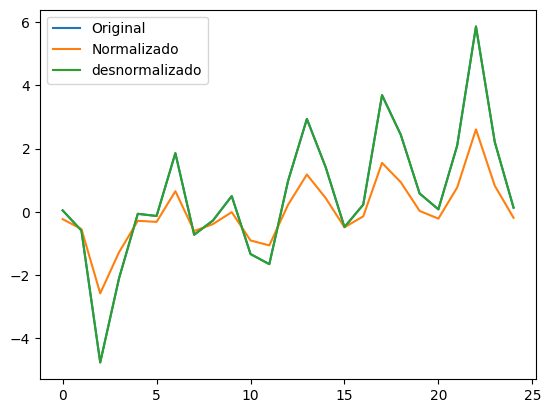

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:11:30.783015: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:11:30.787586: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:11:30.808452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753135890.826470  828692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753135890.837949  828692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753135890.860421  828692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_training_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_5,0.755195,0.512247,0.692058,0.669219,1.027393,3.261606,1.101490,0.873305,1.818979,1.013604,0.160669,1.056755,33.945950,54.666840
model_1_1_4,0.752745,0.510155,0.688465,0.681051,1.037678,3.275596,1.114341,0.842069,1.823804,1.018665,0.152267,1.062031,33.926029,54.646918
model_1_1_3,0.750211,0.508012,0.684768,0.692857,1.048312,3.289926,1.127568,0.810898,1.828556,1.023871,0.143579,1.067460,33.905637,54.626526
model_1_1_2,0.747589,0.505814,0.680963,0.704617,1.059316,3.304621,1.141175,0.779850,1.833286,1.029231,0.134590,1.073047,33.884753,54.605642
model_1_1_1,0.744873,0.503558,0.677048,0.716314,1.070712,3.319710,1.155180,0.748970,1.838080,1.034752,0.125280,1.078804,33.863352,54.584241
model_1_1_0,0.742060,0.501238,0.673019,0.727926,1.082518,3.335221,1.169593,0.718311,1.843010,1.040441,0.115635,1.084735,33.841420,54.562309


DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_4,0.833753,0.559571,0.707034,0.672932,0.697704,2.945147,1.047923,0.488317,1.591537,0.835286,0.430010,0.870846,34.719922,55.440811
model_1_2_5,0.839737,0.556472,0.698148,0.642090,0.672590,2.965875,1.079708,0.534364,1.695181,0.820116,0.450527,0.855030,34.793239,55.514128
model_1_2_8,0.861540,0.552899,0.686460,0.559759,0.581086,2.989763,1.121513,0.657286,1.682758,0.762290,0.525281,0.794742,35.085713,55.806602
model_1_2_3,0.819207,0.552787,0.713067,0.700839,0.758748,2.990516,1.026341,0.446651,1.663004,0.871061,0.380140,0.908144,34.552171,55.273060
model_1_2_9,0.861617,0.552212,0.685681,0.554415,0.580764,2.994359,1.124301,0.665265,1.699379,0.762079,0.525544,0.794522,35.086821,55.807710
model_1_2_2,0.808406,0.548909,0.720382,0.731966,0.804078,3.016448,1.000177,0.400179,1.576886,0.896704,0.343107,0.934878,34.436119,55.157008
model_1_2_1,0.799228,0.546978,0.722655,0.759577,0.842597,3.029358,0.992048,0.358955,1.357952,0.917931,0.311639,0.957009,34.342534,55.063423
model_1_2_0,0.790276,0.542595,0.723892,0.825704,0.880167,3.058672,0.987622,0.260226,1.401140,0.938172,0.280946,0.978112,34.255287,54.976176
model_1_2_7,0.843777,0.540760,0.690826,0.605378,0.655636,3.070939,1.105898,0.589177,1.823617,0.809713,0.464377,0.844184,34.844300,55.565189
model_1_2_6,0.842107,0.537927,0.690956,0.608956,0.662642,3.089881,1.105433,0.583834,1.837068,0.814028,0.458653,0.848683,34.823040,55.543929


DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_4,0.863143,0.584613,0.707202,0.075654,0.574361,2.777693,1.047320,0.738975,2.177396,0.757866,0.530775,0.790130,35.108994,55.829883
model_1_3_3,0.866233,0.580749,0.703346,0.462868,0.561391,2.803536,1.061114,0.429414,2.119902,0.749261,0.541370,0.781158,35.154674,55.875563
model_1_3_5,0.857333,0.571032,0.711743,-0.443641,0.598744,2.868511,1.031080,1.154129,2.214204,0.773785,0.510855,0.806727,35.025843,55.746732
model_1_3_6,0.856702,0.565371,0.712373,-0.502211,0.601392,2.906364,1.028826,1.200953,2.216262,0.775495,0.508692,0.808509,35.017018,55.737907
model_1_3_2,0.868357,0.562567,0.693069,0.943381,0.552477,2.925120,1.097874,0.045264,1.733007,0.743288,0.548653,0.774931,35.186686,55.907575
model_1_3_1,0.868548,0.562286,0.692290,0.956902,0.551675,2.926998,1.100661,0.034455,1.673423,0.742748,0.549308,0.774369,35.189592,55.910481
model_1_3_0,0.868572,0.561909,0.691430,0.965620,0.551577,2.929515,1.103738,0.027485,1.612181,0.742682,0.549388,0.774300,35.189948,55.910837


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_2,0.905556,0.504695,0.643611,0.759037,0.396362,3.312109,1.274781,0.229341,2.196435,0.629573,0.676191,0.656375,35.850854,56.571744
model_1_11_1,0.905376,0.503208,0.643506,0.760841,0.397116,3.322051,1.275157,0.227623,2.198813,0.630171,0.675576,0.656999,35.847056,56.567945
model_1_11_0,0.904994,0.500213,0.643295,0.764568,0.398718,3.342077,1.275913,0.224076,2.204089,0.631441,0.674267,0.658323,35.839001,56.559890


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_8,0.891416,0.646394,0.642148,0.924897,0.455706,2.364562,1.280015,0.576982,1.766090,0.675060,0.627710,0.703798,35.571816,56.292705
model_1_13_7,0.891520,0.645062,0.642363,0.926850,0.455267,2.373471,1.279246,0.561978,1.768612,0.674735,0.628069,0.703459,35.573744,56.294633
model_1_13_6,0.891215,0.631020,0.638156,0.941782,0.456548,2.467370,1.294296,0.447260,1.831754,0.675684,0.627022,0.704449,35.568121,56.289010
model_1_13_5,0.890869,0.628760,0.637297,0.943553,0.458000,2.482480,1.297366,0.433657,1.852914,0.676757,0.625837,0.705568,35.561774,56.282663
model_1_13_4,0.890462,0.623835,0.637327,0.947018,0.459706,2.515415,1.297259,0.407034,1.868341,0.678016,0.624443,0.706881,35.554337,56.275226
model_1_13_3,0.890453,0.621123,0.636840,0.948709,0.459747,2.533552,1.299002,0.394046,1.861605,0.678046,0.624409,0.706912,35.554158,56.275047
model_1_13_2,0.890264,0.618260,0.635682,0.950372,0.460539,2.552696,1.303143,0.381271,1.864342,0.678630,0.623762,0.707521,35.550716,56.271606
model_1_13_1,0.886851,0.574866,0.630366,0.965725,0.474861,2.842876,1.322161,0.263317,1.892397,0.689102,0.612062,0.718438,35.489467,56.210356
model_1_13_0,0.886064,0.561300,0.629377,0.968421,0.478166,2.933592,1.325697,0.242609,1.869795,0.691496,0.609361,0.720934,35.475593,56.196482


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.891811,0.648116,0.639208,0.907457,0.454047,2.353050,1.290532,0.107504,1.783565,0.673830,0.629065,0.702517,35.579107,56.299996
model_1_14_1,0.888194,0.632761,0.562287,0.493029,0.469224,2.455730,1.565673,0.588932,2.051206,0.684999,0.616667,0.714161,35.513349,56.234238
model_1_14_2,0.887472,0.631649,0.557615,0.462548,0.472256,2.463168,1.582385,0.624341,2.070437,0.687208,0.614190,0.716464,35.500470,56.221359
model_1_14_3,0.885446,0.628915,0.543531,0.382687,0.480757,2.481445,1.632765,0.717112,2.103297,0.693366,0.607245,0.722884,35.464789,56.185678
model_1_14_4,0.884934,0.628369,0.540943,0.363459,0.482906,2.485100,1.642020,0.739448,2.100182,0.694914,0.605489,0.724498,35.455868,56.176757
model_1_14_5,0.884545,0.627822,0.538170,0.348737,0.484539,2.488757,1.651938,0.756551,2.107952,0.696089,0.604155,0.725723,35.449113,56.170002
model_1_14_6,0.884154,0.627269,0.535419,0.334109,0.486182,2.492455,1.661778,0.773544,2.115518,0.697267,0.602813,0.726952,35.442345,56.163234
model_1_14_7,0.883644,0.626732,0.534007,0.315331,0.488323,2.496046,1.666830,0.795358,2.111534,0.698801,0.601064,0.728550,35.433557,56.154446
model_1_14_8,0.881969,0.624574,0.523550,0.254425,0.495349,2.510478,1.704234,0.866110,2.127431,0.703810,0.595324,0.733773,35.404986,56.125875
model_1_14_9,0.881090,0.623503,0.518598,0.222892,0.499042,2.517635,1.721946,0.902741,2.128383,0.706429,0.592307,0.736503,35.390132,56.111021


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_2,0.665447,0.518970,0.468690,-4.219589,1.404048,3.216653,1.900466,3.732881,2.088467,1.184925,-0.147039,1.235370,33.321281,54.042170
model_2_0_0,0.689465,0.510020,0.398194,0.579627,1.303247,3.276500,2.152624,0.300637,2.344108,1.141599,-0.064690,1.190199,33.470282,54.191171
model_2_0_1,0.678252,0.508732,0.415867,0.183491,1.350309,3.285111,2.089409,0.583941,2.413131,1.162028,-0.103137,1.211498,33.399333,54.120222


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_1,0.612324,0.592282,0.207733,-0.331600,1.626995,2.726410,2.833893,6.104364,2.303578,1.275537,-0.329176,1.329839,33.026531,53.747420
model_2_1_0,0.724981,0.551404,0.472836,0.231655,1.154198,2.999766,1.885634,3.522269,1.701969,1.074336,0.057076,1.120073,33.713189,54.434078


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_2,0.865313,0.709423,0.569575,0.791122,0.565253,1.943091,1.539604,0.761528,2.583118,0.751833,0.538216,0.783840,35.140965,55.861854
model_2_4_1,0.865557,0.679836,0.558720,0.797142,0.564227,2.140940,1.578431,0.739582,2.559895,0.751150,0.539054,0.783129,35.144597,55.865486
model_2_4_0,0.865370,0.640884,0.546419,0.801097,0.565014,2.401413,1.622433,0.725162,2.538846,0.751674,0.538411,0.783674,35.141811,55.862700


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_0,0.859318,0.761620,0.589115,0.898360,0.590414,1.594048,1.469711,0.621971,2.751294,0.768384,0.51766,0.801096,35.053863,55.774752
model_2_5_1,0.847966,0.728349,0.601694,0.767232,0.638055,1.816529,1.424719,1.424387,2.043521,0.798784,0.47874,0.832790,34.898661,55.619550


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_8,0.805676,0.639073,0.516239,0.260800,0.815536,2.413524,1.730385,1.841829,1.106889,0.903070,0.333747,0.941516,34.407820,55.128709
model_3_2_7,0.781343,0.572562,0.553357,0.503492,0.917657,2.858278,1.597617,1.237127,1.091643,0.957944,0.250319,0.998726,34.171864,54.892753
model_3_2_6,0.779960,0.572014,0.554872,0.510121,0.923459,2.861941,1.592198,1.220608,1.092233,0.960968,0.245579,1.001878,34.159258,54.880147
model_3_2_5,0.778907,0.571700,0.556384,0.517444,0.927880,2.864044,1.586787,1.202363,1.093317,0.963265,0.241967,1.004274,34.149705,54.870594
model_3_2_4,0.755849,0.558264,0.568580,0.629905,1.024648,2.953891,1.543165,0.922149,1.114670,1.012249,0.162912,1.055343,33.951301,54.672191
model_3_2_3,0.744679,0.550401,0.566568,0.669862,1.071527,3.006467,1.550363,0.822590,1.127184,1.035146,0.124614,1.079214,33.861830,54.582719
model_3_2_2,0.728374,0.538342,0.558035,0.720861,1.139955,3.087111,1.580883,0.695518,1.154226,1.067687,0.068712,1.113140,33.738022,54.458911
model_3_2_1,0.705505,0.521422,0.543854,0.748192,1.235932,3.200252,1.631609,0.627418,1.185902,1.111725,-0.009697,1.159053,33.576349,54.297238
model_3_2_0,0.693624,0.512567,0.536108,0.755277,1.285795,3.259470,1.659317,0.609765,1.202603,1.133929,-0.050433,1.182203,33.497245,54.218134


DataFrame salvo em ./content/results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_3,0.848701,0.647907,0.502451,0.921793,0.634968,2.354444,1.779705,0.199089,1.003962,0.796849,0.481261,0.830773,34.908360,55.629249
model_3_3_2,0.847268,0.646369,0.502460,0.920893,0.640983,2.364734,1.779671,0.201380,1.004295,0.800614,0.476348,0.834698,34.889506,55.610395
model_3_3_9,0.891134,0.645211,0.478951,0.935623,0.456889,2.372473,1.863762,0.163884,1.033317,0.675936,0.626744,0.704711,35.566630,56.287519
model_3_3_4,0.850100,0.643546,0.500752,0.922671,0.629098,2.383612,1.785780,0.196855,1.003568,0.793157,0.486057,0.826924,34.926935,55.647824
model_3_3_8,0.882054,0.638674,0.488017,0.937330,0.494995,2.416190,1.831333,0.159537,1.003665,0.703559,0.595613,0.733511,35.406416,56.127305
model_3_3_7,0.873878,0.632958,0.493244,0.935611,0.529308,2.454413,1.812638,0.163913,0.985259,0.727536,0.567581,0.758508,35.272369,55.993258
model_3_3_1,0.831042,0.632807,0.500626,0.909262,0.709080,2.455423,1.786232,0.230988,1.023162,0.842069,0.420716,0.877918,34.687573,55.408462
model_3_3_6,0.873129,0.632536,0.493200,0.935253,0.532450,2.457232,1.812796,0.164824,0.986931,0.729692,0.565014,0.760756,35.260532,55.981421
model_3_3_5,0.868657,0.629592,0.495412,0.933622,0.551218,2.476919,1.804883,0.168976,0.985029,0.742441,0.549681,0.774048,35.191248,55.912137
model_3_3_0,0.810431,0.623165,0.484906,0.892288,0.795582,2.519900,1.842461,0.274200,1.072769,0.891954,0.350048,0.929926,34.457363,55.178252


DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_0,0.893930,0.647009,0.480195,0.548065,0.445153,2.360454,1.859313,0.708191,0.992892,0.667198,0.636332,0.695602,35.618675,56.339564
model_3_4_1,0.894449,0.644072,0.480297,0.540676,0.442977,2.380095,1.858948,0.719770,0.981819,0.665565,0.638110,0.693899,35.628477,56.349366
model_3_4_2,0.895819,0.641710,0.481393,0.512507,0.437225,2.395887,1.855026,0.763911,0.938972,0.661230,0.642808,0.689380,35.654614,56.375503
model_3_4_3,0.896294,0.639070,0.483438,0.486275,0.435230,2.413538,1.847711,0.805017,0.895957,0.659720,0.644438,0.687805,35.663761,56.384650
model_3_4_4,0.896753,0.637846,0.483717,0.470731,0.433307,2.421725,1.846715,0.829375,0.876872,0.658260,0.646009,0.686284,35.672619,56.393508
model_3_4_5,0.896887,0.636768,0.484005,0.463287,0.432742,2.428932,1.845684,0.841039,0.867323,0.657831,0.646471,0.685837,35.675227,56.396116
model_3_4_6,0.897468,0.634483,0.483766,0.438153,0.430304,2.444214,1.846539,0.880425,0.840852,0.655976,0.648462,0.683902,35.686525,56.407414
model_3_4_7,0.897024,0.627159,0.486517,0.376859,0.432169,2.493189,1.836697,0.976474,0.769574,0.657396,0.646939,0.685383,35.677876,56.398765
model_3_4_8,0.895797,0.614781,0.485717,0.272001,0.437319,2.575961,1.839561,1.140788,0.684075,0.661301,0.642732,0.689454,35.654186,56.375075
model_3_4_9,0.895509,0.612076,0.485078,0.253824,0.438528,2.594052,1.841846,1.169271,0.673811,0.662215,0.641744,0.690406,35.648662,56.369551


DataFrame salvo em ./content/results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_0,0.899884,0.590039,0.416150,0.881900,0.420165,2.741410,2.088399,0.265802,0.765594,0.648202,0.656745,0.675797,35.734214,56.455103
model_3_5_1,0.899797,0.573539,0.374017,0.835196,0.420529,2.851747,2.239104,0.370914,0.876825,0.648482,0.656448,0.676089,35.732484,56.453373
model_3_5_2,0.891680,0.547735,0.317021,0.704678,0.454595,3.024297,2.442977,0.664664,1.104578,0.674237,0.628618,0.702940,35.576696,56.297585
model_3_5_3,0.889198,0.530387,0.281812,0.654628,0.465011,3.140302,2.568918,0.777308,1.193228,0.681917,0.620108,0.710948,35.531387,56.252276
model_3_5_4,0.888609,0.526793,0.274559,0.643850,0.467483,3.164338,2.594859,0.801566,1.210931,0.683727,0.618089,0.712835,35.520786,56.241675
model_3_5_5,0.887993,0.523146,0.267266,0.632855,0.470068,3.188724,2.620947,0.826311,1.228549,0.685615,0.615977,0.714803,35.509754,56.230643
model_3_5_6,0.887346,0.519434,0.259942,0.621642,0.472786,3.213549,2.647143,0.851548,1.246126,0.687594,0.613757,0.716867,35.498225,56.219114


DataFrame salvo em ./content/results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  20
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_7,0.903240,0.592992,0.314618,0.768465,0.406083,2.721665,2.451573,0.589744,1.690608,0.637246,0.668250,0.664375,35.802396,56.523285
model_3_6_2,0.898017,0.591344,0.293054,0.781437,0.428002,2.732685,2.528706,0.556702,1.677936,0.654219,0.650343,0.682070,35.697255,56.418144
model_3_6_6,0.902769,0.589346,0.310317,0.771261,0.408058,2.746048,2.466956,0.582621,1.689476,0.638794,0.666637,0.665989,35.792693,56.513582
model_3_6_5,0.902353,0.588841,0.308666,0.772199,0.409804,2.749423,2.472861,0.580233,1.688767,0.640159,0.665210,0.667412,35.784154,56.505043
model_3_6_4,0.901972,0.587512,0.306866,0.773253,0.411404,2.758309,2.479299,0.577549,1.688054,0.641408,0.663903,0.668714,35.776358,56.497247
model_3_6_3,0.898524,0.586346,0.297696,0.778498,0.425874,2.766103,2.512101,0.564188,1.680150,0.652591,0.652081,0.680373,35.707221,56.428111
model_3_6_1,0.892536,0.556951,0.260415,0.799512,0.451004,2.962671,2.645454,0.510663,1.655126,0.671569,0.631551,0.700159,35.592557,56.313446
model_3_6_0,0.888895,0.542314,0.241321,0.807591,0.466286,3.060549,2.713751,0.490086,1.642138,0.682851,0.619067,0.711922,35.525913,56.246802


DataFrame salvo em ./content/results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  11
1/1 ━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_8,0.911478,0.671021,0.447952,-6.300228,0.371510,2.199884,1.974645,0.746630,1.961868,0.609516,0.696495,0.635464,35.980361,56.701250
model_3_7_9,0.911499,0.669561,0.448303,-6.398389,0.371422,2.209645,1.973388,0.756670,1.972851,0.609444,0.696567,0.635389,35.980835,56.701724
model_3_7_1,0.905364,0.665148,0.447933,-4.317730,0.397166,2.239159,1.974712,0.543871,1.685929,0.630211,0.675535,0.657040,35.846802,56.567691
model_3_7_7,0.910392,0.663105,0.487809,-5.692376,0.376065,2.252818,1.832076,0.684462,1.891821,0.613241,0.692773,0.639348,35.955988,56.676877
model_3_7_4,0.908811,0.661791,0.479631,-5.237261,0.382701,2.261604,1.861331,0.637916,1.834054,0.618629,0.687352,0.644965,35.921001,56.641890
model_3_7_0,0.904981,0.661632,0.388357,-4.304771,0.398774,2.262669,2.187813,0.542545,1.687526,0.631486,0.674221,0.658369,35.838721,56.559610
model_3_7_6,0.909249,0.661027,0.443379,-5.337981,0.380861,2.266713,1.991000,0.648217,1.847259,0.617139,0.688855,0.643412,35.930642,56.651531
model_3_7_5,0.909035,0.660896,0.448265,-5.287524,0.381760,2.267591,1.973523,0.643056,1.840694,0.617868,0.688120,0.644172,35.925924,56.646813
model_3_7_3,0.907127,0.649561,0.326429,-4.664418,0.389769,2.343387,2.409323,0.579328,1.747139,0.624315,0.681577,0.650894,35.884400,56.605289
model_3_7_2,0.905780,0.644901,0.320293,-4.362109,0.395421,2.374548,2.431273,0.548409,1.694224,0.628825,0.676960,0.655596,35.855607,56.576496


DataFrame salvo em ./content/results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  15
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_8,0.911715,0.691169,0.525637,0.859266,0.370513,2.065156,1.696770,0.547570,1.763746,0.608698,0.697309,0.634611,35.985734,56.706623
model_3_8_7,0.911761,0.689245,0.524476,0.860494,0.370318,2.078018,1.700921,0.542792,1.767705,0.608538,0.697468,0.634445,35.986785,56.707674
model_3_8_6,0.912482,0.687919,0.517049,0.869712,0.367293,2.086884,1.727487,0.506929,1.792108,0.606047,0.699940,0.631847,36.003192,56.724081
model_3_8_9,0.911674,0.687795,0.528611,0.858073,0.370687,2.087714,1.686130,0.552214,1.759823,0.608841,0.697166,0.634761,35.984792,56.705681
model_3_8_5,0.912847,0.685599,0.507580,0.879221,0.365762,2.102399,1.761356,0.469929,1.821897,0.604783,0.701190,0.630530,36.011544,56.732433
model_3_8_4,0.913142,0.682340,0.495420,0.890451,0.364523,2.124193,1.804854,0.426236,1.857459,0.603758,0.702202,0.629461,36.018330,56.739219
model_3_8_3,0.913149,0.681809,0.477957,0.904650,0.364495,2.127746,1.867318,0.370991,1.903683,0.603734,0.702225,0.629437,36.018484,56.739373
model_3_8_2,0.913108,0.681504,0.476035,0.906027,0.364667,2.129785,1.874192,0.365632,1.908516,0.603876,0.702085,0.629585,36.017544,56.738433
model_3_8_1,0.912966,0.680755,0.474158,0.907085,0.365262,2.134792,1.880906,0.361516,1.913334,0.604369,0.701599,0.630098,36.014283,56.735172
model_3_8_0,0.913049,0.660908,0.468419,0.913638,0.364916,2.267512,1.901435,0.336021,1.932438,0.604083,0.701881,0.629800,36.016174,56.737063


DataFrame salvo em ./content/results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_1,0.915035,0.693844,0.531797,0.890243,0.356581,2.047267,1.674736,0.579740,1.655783,0.597144,0.708690,0.622566,36.062387,56.783276
model_3_9_2,0.915258,0.693822,0.532060,0.888745,0.355643,2.047411,1.673794,0.587652,1.647562,0.596358,0.709457,0.621746,36.067655,56.788544
model_3_9_3,0.915501,0.693625,0.532280,0.887240,0.354626,2.048733,1.673007,0.595600,1.639570,0.595504,0.710288,0.620856,36.073386,56.794275
model_3_9_0,0.912305,0.689018,0.528124,0.905154,0.368037,2.079538,1.687873,0.500981,1.741707,0.606660,0.699332,0.632487,35.999146,56.720035
model_3_9_9,0.915384,0.683313,0.496435,0.846447,0.355117,2.117685,1.801222,0.811069,1.444985,0.595917,0.709887,0.621286,36.070616,56.791505
model_3_9_5,0.913995,0.682737,0.493078,0.865179,0.360945,2.121541,1.813232,0.712124,1.532689,0.600787,0.705125,0.626364,36.038059,56.758948
model_3_9_6,0.914171,0.682494,0.493387,0.863724,0.360207,2.123165,1.812124,0.719814,1.525634,0.600172,0.705728,0.625723,36.042154,56.763043
model_3_9_7,0.914636,0.682020,0.494226,0.859372,0.358254,2.126331,1.809124,0.742799,1.504746,0.598543,0.707324,0.624024,36.053029,56.773918
model_3_9_8,0.914778,0.682010,0.494464,0.857929,0.357657,2.126399,1.808273,0.750422,1.497866,0.598044,0.707811,0.623504,36.056362,56.777251
model_3_9_4,0.912587,0.681392,0.490126,0.875463,0.366854,2.130535,1.823788,0.657809,1.583660,0.605685,0.700298,0.631470,36.005581,56.726470


DataFrame salvo em ./content/results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_6,0.919768,0.687401,0.473044,0.943646,0.336718,2.090350,1.884892,0.108415,1.475723,0.580274,0.724918,0.604977,36.177021,56.897910
model_3_10_7,0.919910,0.686688,0.472120,0.943198,0.336119,2.095122,1.888196,0.109277,1.476965,0.579758,0.725407,0.604439,36.180579,56.901468
model_3_10_8,0.920050,0.686433,0.471203,0.942750,0.335534,2.096822,1.891475,0.110138,1.478202,0.579253,0.725885,0.603913,36.184067,56.904956
model_3_10_5,0.918976,0.684575,0.478502,0.946658,0.340039,2.109248,1.865366,0.102620,1.467780,0.583129,0.722204,0.607954,36.157389,56.878278
model_3_10_2,0.917334,0.684383,0.487578,0.951109,0.346933,2.110533,1.832905,0.094057,1.455486,0.589011,0.716572,0.614086,36.117244,56.838133
model_3_10_9,0.920182,0.684315,0.470295,0.942298,0.334977,2.110988,1.894724,0.111007,1.479419,0.578772,0.726340,0.603412,36.187386,56.908275
model_3_10_0,0.915629,0.683994,0.495414,0.954618,0.354087,2.113137,1.804876,0.087307,1.445819,0.595052,0.710728,0.620385,36.076423,56.797313
model_3_10_1,0.915874,0.683925,0.494389,0.954187,0.353058,2.113596,1.808541,0.088135,1.446848,0.594187,0.711569,0.619482,36.082248,56.803137
model_3_10_3,0.917537,0.683233,0.486598,0.950670,0.346081,2.118222,1.836408,0.094901,1.456741,0.588287,0.717268,0.613331,36.122163,56.843052
model_3_10_4,0.917733,0.683120,0.485625,0.950226,0.345258,2.118978,1.839890,0.095756,1.458051,0.587586,0.717941,0.612601,36.126928,56.847817


DataFrame salvo em ./content/results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  14
1/1 ━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_1,0.915668,0.695209,0.505801,0.951416,0.353924,2.038137,1.767722,0.594498,1.416789,0.594915,0.710861,0.620242,36.077344,56.798233
model_3_11_4,0.911127,0.694114,0.519031,0.938678,0.372983,2.045464,1.720399,0.750360,1.377734,0.610723,0.695291,0.636723,35.972445,56.693334
model_3_11_2,0.914980,0.693984,0.504918,0.949356,0.356811,2.046333,1.770881,0.619694,1.410042,0.597336,0.708503,0.622766,36.061100,56.781989
model_3_11_5,0.910734,0.693716,0.520228,0.937631,0.374630,2.048123,1.716118,0.763174,1.374646,0.612071,0.693945,0.638128,35.963631,56.684520
model_3_11_6,0.910340,0.692523,0.521404,0.936584,0.376286,2.056103,1.711910,0.775985,1.371578,0.613421,0.692593,0.639536,35.954813,56.675702
model_3_11_7,0.909942,0.692421,0.522562,0.935536,0.377955,2.056783,1.707769,0.788804,1.368522,0.614781,0.691229,0.640953,35.945959,56.666848
model_3_11_3,0.914627,0.692246,0.506393,0.948320,0.358292,2.057951,1.765603,0.632375,1.406700,0.598575,0.707293,0.624058,36.052813,56.773702
model_3_11_8,0.909542,0.692113,0.523691,0.934491,0.379631,2.058843,1.703728,0.801598,1.365487,0.616142,0.689860,0.642373,35.937109,56.657998
model_3_11_9,0.905876,0.687907,0.532734,0.925187,0.395017,2.086969,1.671384,0.915435,1.339509,0.628504,0.677290,0.655261,35.857651,56.578540
model_3_11_0,0.919534,0.687759,0.476954,0.964406,0.337697,2.087954,1.870906,0.435547,1.466947,0.581117,0.724118,0.605857,36.171210,56.892099


DataFrame salvo em ./content/results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_5,0.907273,0.695393,0.553108,0.806302,0.389154,2.036910,1.598506,1.373443,1.223249,0.623822,0.682080,0.650379,35.887562,56.608452
model_3_12_4,0.907275,0.695211,0.553291,0.806659,0.389146,2.038126,1.597853,1.370910,1.225783,0.623816,0.682086,0.650373,35.887600,56.608489
model_3_12_3,0.907280,0.695107,0.553470,0.807027,0.389125,2.038820,1.597214,1.368302,1.228358,0.623799,0.682103,0.650356,35.887707,56.608596
model_3_12_2,0.907277,0.695076,0.553647,0.807388,0.389137,2.039028,1.596579,1.365742,1.230935,0.623809,0.682094,0.650366,35.887646,56.608535
model_3_12_1,0.907268,0.694892,0.553997,0.808117,0.389175,2.040261,1.595328,1.360576,1.236165,0.623839,0.682063,0.650397,35.887454,56.608344
model_3_12_0,0.907260,0.688676,0.554665,0.809260,0.389209,2.081827,1.592939,1.352470,1.244267,0.623866,0.682035,0.650426,35.887276,56.608165
model_3_12_6,0.838974,0.674663,0.534245,0.590251,0.675792,2.175532,1.665980,2.905383,1.166353,0.822066,0.447910,0.857063,34.783739,55.504628
model_3_12_8,0.838392,0.673473,0.530278,0.586595,0.678234,2.183485,1.680169,2.931309,1.141946,0.823550,0.445916,0.858610,34.776526,55.497415
model_3_12_7,0.838435,0.673028,0.525889,0.586867,0.678055,2.186465,1.695867,2.929380,1.143457,0.823441,0.446062,0.858497,34.777053,55.497942
model_3_12_9,0.838114,0.669184,0.512132,0.584807,0.679399,2.212166,1.745077,2.943982,1.131502,0.824257,0.444963,0.859347,34.773092,55.493981


DataFrame salvo em ./content/results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_5,0.870859,0.674201,0.554001,0.804068,0.541976,2.178623,1.595314,1.038477,1.241884,0.736190,0.557232,0.767532,35.225066,55.945955
model_3_13_0,0.845699,0.673645,0.517450,0.847286,0.647569,2.182336,1.726054,0.809414,1.172940,0.804717,0.470967,0.838975,34.869059,55.589948
model_3_13_9,0.873568,0.673580,0.565900,0.773196,0.530607,2.182774,1.552751,1.202110,1.287503,0.728427,0.566520,0.759438,35.267469,55.988358
model_3_13_7,0.870209,0.673163,0.559934,0.792095,0.544705,2.185559,1.574090,1.101941,1.254666,0.738041,0.555003,0.769461,35.215023,55.935912
model_3_13_6,0.869296,0.672644,0.559534,0.793564,0.548538,2.189029,1.575522,1.094154,1.249469,0.740634,0.551871,0.772164,35.200996,55.921885
model_3_13_8,0.871080,0.672641,0.560360,0.790568,0.541050,2.189051,1.572568,1.110033,1.259374,0.735561,0.557988,0.766876,35.228486,55.949375
model_3_13_2,0.853011,0.671970,0.518248,0.850636,0.616881,2.193538,1.723198,0.791662,1.209906,0.785418,0.496038,0.818855,34.966158,55.687047
model_3_13_1,0.849379,0.670635,0.517111,0.848806,0.632125,2.202464,1.727264,0.801359,1.191194,0.795063,0.483585,0.828910,34.917337,55.638227
model_3_13_4,0.850678,0.661928,0.546979,0.806956,0.626671,2.260692,1.620429,1.023170,1.136031,0.791625,0.488040,0.825327,34.934668,55.655557
model_3_13_3,0.848832,0.661085,0.546557,0.805436,0.634421,2.266328,1.621939,1.031227,1.127348,0.796506,0.481709,0.830414,34.910085,55.630974


DataFrame salvo em ./content/results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_8,0.904920,0.686314,0.535568,0.940896,0.399031,2.097621,1.661247,0.165661,1.277895,0.631689,0.674011,0.658582,35.837430,56.558319
model_3_14_6,0.903805,0.686169,0.537726,0.942341,0.403710,2.098587,1.653528,0.161611,1.271649,0.635382,0.670188,0.662431,35.814116,56.535005
model_3_14_7,0.904372,0.686028,0.536654,0.941631,0.401331,2.099529,1.657362,0.163601,1.274794,0.633507,0.672132,0.660477,35.825937,56.546826
model_3_14_9,0.905455,0.685419,0.534471,0.940144,0.396787,2.103605,1.665172,0.167769,1.281141,0.629910,0.675844,0.656727,35.848713,56.569602
model_3_14_3,0.897722,0.679443,0.547676,0.947969,0.429240,2.143565,1.617935,0.145836,1.247972,0.655164,0.649332,0.683056,35.691480,56.412369
model_3_14_5,0.898787,0.679403,0.545641,0.947269,0.424769,2.143834,1.625216,0.147796,1.249256,0.651743,0.652985,0.679489,35.712421,56.433310
model_3_14_4,0.898080,0.679090,0.546587,0.947763,0.427736,2.145925,1.621833,0.146412,1.247360,0.654016,0.650560,0.681858,35.698496,56.419386
model_3_14_1,0.892229,0.675908,0.553382,0.948629,0.452290,2.167203,1.597526,0.143986,1.256867,0.672525,0.630501,0.701156,35.586865,56.307754
model_3_14_2,0.894770,0.675116,0.551125,0.948408,0.441627,2.172501,1.605599,0.144604,1.251818,0.664550,0.639212,0.692841,35.634580,56.355469
model_3_14_0,0.875331,0.674232,0.564918,0.949479,0.523210,2.178415,1.556264,0.141604,1.284839,0.723333,0.572563,0.754126,35.295544,56.016433


DataFrame salvo em ./content/results/metrics_3_14
Testando combinacao4: Hidden Size=[4], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_1,0.857475,0.664159,0.592398,0.504957,0.598148,2.245768,1.457969,0.774695,1.613988,0.773400,0.511342,0.806326,35.027833,55.748722
model_4_0_0,0.804930,0.594954,0.562277,0.848404,0.818669,2.708541,1.565709,0.237233,1.176803,0.904803,0.331187,0.943322,34.400152,55.121041
model_4_0_2,0.894883,0.580468,0.729917,0.061436,0.441155,2.805414,0.966071,1.468762,1.001391,0.664195,0.639598,0.692471,35.636717,56.357606
model_4_0_3,0.899180,0.568135,0.738389,0.065090,0.423121,2.887883,0.935767,1.463044,1.028781,0.650477,0.654331,0.678170,35.720195,56.441084
model_4_0_4,0.899558,0.565760,0.739539,0.064510,0.421532,2.903762,0.931654,1.463952,1.045417,0.649255,0.655628,0.676895,35.727717,56.448606
model_4_0_5,0.900262,0.557037,0.743054,0.059857,0.418580,2.962097,0.919081,1.471233,1.099740,0.646977,0.658041,0.674520,35.741776,56.462665
model_4_0_6,0.900295,0.556232,0.743729,0.058202,0.418440,2.967478,0.916668,1.473824,1.110826,0.646870,0.658154,0.674408,35.742441,56.463330
model_4_0_7,0.900301,0.554424,0.744343,0.056544,0.418416,2.979570,0.914472,1.476419,1.121057,0.646851,0.658175,0.674388,35.742560,56.463449


DataFrame salvo em ./content/results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_2,0.893874,0.673255,0.703858,-0.482306,0.445387,2.184942,1.059281,1.677815,0.962984,0.667373,0.636141,0.695784,35.617625,56.338514
model_4_1_3,0.874164,0.656002,0.702310,-0.849777,0.528107,2.300314,1.064819,2.093753,0.986620,0.726710,0.568562,0.757647,35.276912,55.997801
model_4_1_5,0.867485,0.651726,0.698242,-0.979282,0.556138,2.328908,1.079371,2.240339,0.991710,0.745746,0.545662,0.777494,35.173479,55.894368
model_4_1_4,0.867961,0.651509,0.699508,-0.968834,0.554138,2.330363,1.074841,2.228513,0.992091,0.744404,0.547296,0.776095,35.180685,55.901574
model_4_1_0,0.911502,0.649843,0.753696,0.246214,0.371406,2.341499,0.881013,0.853207,0.858940,0.609431,0.696579,0.635376,35.980920,56.701809
model_4_1_1,0.870956,0.633291,0.729357,-0.817087,0.541572,2.452184,0.968074,2.056752,0.939259,0.735916,0.557562,0.767245,35.226558,55.947447
model_4_1_7,0.847677,0.632203,0.695950,-1.348919,0.639268,2.459461,1.087570,2.658730,1.008648,0.799542,0.477749,0.833580,34.894864,55.615753
model_4_1_6,0.848157,0.631892,0.697059,-1.338787,0.637253,2.461542,1.083603,2.647261,1.008027,0.798281,0.479395,0.832266,34.901178,55.622067
model_4_1_9,0.825301,0.612846,0.689227,-1.769284,0.733175,2.588898,1.111616,3.134539,1.022083,0.856256,0.401031,0.892709,34.620741,55.341630
model_4_1_8,0.827855,0.611288,0.693940,-1.718307,0.722454,2.599320,1.094759,3.076838,1.024200,0.849973,0.409790,0.886158,34.650202,55.371091


DataFrame salvo em ./content/results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_0,0.854756,0.708595,0.657037,-0.102152,0.609559,1.948627,1.226758,1.519636,1.052327,0.780743,0.502019,0.813981,34.990038,55.710927
model_4_2_1,0.861712,0.696822,0.643731,-0.184212,0.580364,2.027352,1.274353,1.632779,0.986445,0.761816,0.525870,0.794249,35.088199,55.809088
model_4_2_2,0.865991,0.690987,0.630819,-0.256554,0.562405,2.066368,1.320540,1.732523,0.936640,0.749937,0.540542,0.781863,35.151065,55.871954
model_4_2_3,0.868687,0.685144,0.617948,-0.326524,0.551093,2.105443,1.366578,1.828996,0.892748,0.742357,0.549783,0.773960,35.191702,55.912591
model_4_2_4,0.870412,0.679718,0.605840,-0.389960,0.543853,2.141725,1.409886,1.916461,0.853172,0.737464,0.555699,0.768859,35.218154,55.939043
model_4_2_5,0.874785,0.673607,0.586561,-0.487462,0.525502,2.182593,1.478849,2.050896,0.772174,0.724915,0.570691,0.755776,35.286804,56.007693
model_4_2_6,0.877480,0.660490,0.540919,-0.627868,0.514190,2.270306,1.642106,2.244487,0.631859,0.717070,0.579932,0.747597,35.330327,56.051216
model_4_2_7,0.874410,0.648096,0.522267,-0.680610,0.527075,2.353186,1.708823,2.317207,0.604194,0.725999,0.569405,0.756907,35.280825,56.001714
model_4_2_8,0.869249,0.624207,0.468172,-0.826340,0.548733,2.512930,1.902319,2.518137,0.739499,0.740765,0.551712,0.772301,35.200288,55.921177
model_4_2_9,0.866885,0.619299,0.446819,-0.886586,0.558655,2.545747,1.978698,2.601204,0.841840,0.747432,0.543606,0.779252,35.164445,55.885335


DataFrame salvo em ./content/results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_7,0.864410,0.627613,0.652328,0.799024,0.569042,2.490151,1.243602,1.761631,0.856183,0.754349,0.535120,0.786463,35.127603,55.848492
model_4_3_6,0.865444,0.627412,0.654442,0.807782,0.564702,2.491495,1.236041,1.684863,0.829422,0.751467,0.538665,0.783458,35.142913,55.863802
model_4_3_8,0.860968,0.625252,0.649125,0.787375,0.583486,2.505940,1.255058,1.863741,0.883282,0.763863,0.523320,0.796382,35.077469,55.798358
model_4_3_5,0.864653,0.625236,0.655306,0.814896,0.568021,2.506050,1.232951,1.622510,0.801289,0.753672,0.535954,0.785757,35.131192,55.852081
model_4_3_4,0.862225,0.621344,0.654464,0.821072,0.578212,2.532072,1.235961,1.568373,0.770458,0.760402,0.527629,0.792774,35.095630,55.816519
model_4_3_3,0.858048,0.615723,0.651139,0.826605,0.595742,2.569665,1.247855,1.519875,0.750238,0.771843,0.513308,0.804702,35.035896,55.756785
model_4_3_0,0.861479,0.614623,0.609148,0.886137,0.581345,2.577018,1.398054,0.998048,0.672770,0.762460,0.525069,0.794919,35.084822,55.805711
model_4_3_9,0.838730,0.612156,0.643005,0.728801,0.676817,2.593512,1.276949,2.377162,1.050781,0.822689,0.447073,0.857713,34.780708,55.501597
model_4_3_2,0.854285,0.611425,0.640908,0.834302,0.611534,2.598401,1.284452,1.452409,0.735244,0.782007,0.500406,0.815298,34.983569,55.704458
model_4_3_1,0.853174,0.608309,0.627263,0.850544,0.616198,2.619242,1.333258,1.310035,0.712095,0.784983,0.496596,0.818401,34.968375,55.689264


DataFrame salvo em ./content/results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_0,0.886396,0.732642,0.707880,0.343743,0.476772,1.787827,1.044898,1.626787,1.493814,0.690487,0.610500,0.719882,35.481434,56.202323
model_4_4_9,0.870653,0.720535,0.619165,0.137750,0.542842,1.868785,1.362225,2.137420,1.656804,0.736778,0.556525,0.768144,35.221875,55.942764
model_4_4_8,0.870757,0.720501,0.619359,0.138636,0.542406,1.869009,1.361531,2.135224,1.656306,0.736482,0.556881,0.767836,35.223482,55.944371
model_4_4_7,0.873391,0.720036,0.624409,0.161555,0.531349,1.872119,1.343467,2.078409,1.643254,0.728937,0.565913,0.759969,35.264672,55.985561
model_4_4_6,0.873730,0.719948,0.625062,0.164571,0.529928,1.872711,1.341130,2.070935,1.641498,0.727961,0.567075,0.758952,35.270029,55.990918
model_4_4_5,0.874103,0.719778,0.625772,0.167910,0.528363,1.873846,1.338593,2.062656,1.639546,0.726886,0.568353,0.757831,35.275944,55.996833
model_4_4_4,0.874513,0.719733,0.626581,0.171609,0.526641,1.874146,1.335698,2.053488,1.637372,0.725701,0.569760,0.756595,35.282471,56.003360
model_4_4_3,0.874964,0.719479,0.627439,0.175702,0.524750,1.875843,1.332631,2.043342,1.634954,0.724396,0.571305,0.755235,35.289666,56.010555
model_4_4_2,0.875458,0.719341,0.628409,0.180231,0.522675,1.876771,1.329161,2.032115,1.632262,0.722963,0.573000,0.753741,35.297591,56.018480
model_4_4_1,0.876000,0.718694,0.629414,0.185240,0.520402,1.881096,1.325563,2.019698,1.629266,0.721389,0.574857,0.752100,35.306309,56.027198


DataFrame salvo em ./content/results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.881220,0.720098,0.643568,0.981433,0.498496,1.871703,1.274937,0.111521,1.610700,0.706042,0.592753,0.736100,35.392320,56.113209
model_4_5_1,0.888209,0.718749,0.661955,0.975055,0.469162,1.880725,1.209169,0.149835,1.570471,0.684954,0.616717,0.714114,35.513613,56.234502
model_4_5_2,0.892716,0.716874,0.675939,0.967292,0.450249,1.893265,1.159148,0.196461,1.534304,0.671006,0.632168,0.699572,35.595907,56.316796
model_4_5_9,0.922621,0.716804,0.718075,0.966447,0.324742,1.893735,1.008428,0.201537,1.166452,0.569861,0.734702,0.594121,36.249450,56.970339
model_4_5_3,0.895512,0.714732,0.686662,0.958972,0.438515,1.907591,1.120792,0.246436,1.500752,0.662205,0.641754,0.690396,35.648721,56.369610
model_4_5_4,0.897140,0.712494,0.694942,0.950642,0.431680,1.922557,1.091175,0.296474,1.469776,0.657024,0.647338,0.684995,35.680139,56.401029
model_4_5_5,0.897982,0.710271,0.701374,0.942644,0.428146,1.937418,1.068168,0.344510,1.441283,0.654328,0.650226,0.682185,35.696583,56.417472
model_4_5_6,0.898305,0.708136,0.706396,0.935187,0.426790,1.951696,1.050205,0.389302,1.415151,0.653292,0.651333,0.681104,35.702925,56.423815
model_4_5_7,0.898297,0.706132,0.710334,0.928382,0.426827,1.965094,1.036118,0.430175,1.391232,0.653320,0.651303,0.681133,35.702752,56.423641
model_4_5_8,0.898088,0.704287,0.713434,0.922285,0.427701,1.977432,1.025030,0.466799,1.369370,0.653989,0.650589,0.681831,35.698660,56.419549


DataFrame salvo em ./content/results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_1,0.921483,0.717530,0.707367,0.813038,0.329518,1.888880,1.046733,1.304918,0.885230,0.574037,0.730799,0.598475,36.220246,56.941135
model_4_6_0,0.922690,0.715533,0.716070,0.823735,0.324452,1.902234,1.015601,1.230261,0.934780,0.569607,0.734938,0.593856,36.251235,56.972124
model_4_6_2,0.916503,0.707538,0.689856,0.783781,0.350421,1.955698,1.109366,1.509119,0.754949,0.591963,0.713723,0.617164,36.097242,56.818131
model_4_6_3,0.914683,0.705848,0.684780,0.775194,0.358058,1.966996,1.127523,1.569056,0.718567,0.598379,0.707484,0.623854,36.054121,56.775010
model_4_6_4,0.912876,0.703831,0.680079,0.767219,0.365641,1.980480,1.144340,1.624715,0.685294,0.604683,0.701289,0.630425,36.012207,56.733096
model_4_6_5,0.909431,0.696936,0.671817,0.753110,0.380098,2.026588,1.173892,1.723192,0.627752,0.616520,0.689479,0.642767,35.934655,56.655544
model_4_6_6,0.907838,0.695439,0.668232,0.746944,0.386786,2.036603,1.186714,1.766230,0.602906,0.621921,0.684015,0.648397,35.899769,56.620658
model_4_6_7,0.906341,0.693479,0.664961,0.741315,0.393067,2.049706,1.198416,1.805513,0.580176,0.626951,0.678883,0.653641,35.867550,56.588439
model_4_6_9,0.900344,0.689770,0.652605,0.720028,0.418233,2.074510,1.242613,1.954092,0.492551,0.646709,0.658324,0.674241,35.743433,56.464322
model_4_6_8,0.901354,0.688476,0.654608,0.723488,0.413997,2.083164,1.235447,1.929944,0.507081,0.643426,0.661784,0.670818,35.763791,56.484680


DataFrame salvo em ./content/results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_2,0.917794,0.699688,0.655525,0.942132,0.345002,2.008191,1.232167,0.386447,0.941347,0.587369,0.718150,0.612374,36.128410,56.849299
model_4_7_3,0.908102,0.696369,0.596665,0.889214,0.385678,2.030382,1.442705,0.739839,1.104346,0.621030,0.684920,0.647468,35.905504,56.626393
model_4_7_4,0.898521,0.684711,0.530989,0.852375,0.425886,2.108338,1.677626,0.985855,1.175620,0.652599,0.652072,0.680382,35.707169,56.428058
model_4_7_0,0.901016,0.681016,0.659255,0.989654,0.415416,2.133044,1.218824,0.069089,0.486547,0.644527,0.660626,0.671966,35.756952,56.477841
model_4_7_5,0.892687,0.673277,0.478451,0.831772,0.450370,2.184795,1.865551,1.123441,1.212091,0.671096,0.632070,0.699666,35.595373,56.316262
model_4_7_1,0.897877,0.668224,0.668243,0.978161,0.428590,2.218585,1.186675,0.145841,0.558399,0.654668,0.649863,0.682538,35.694510,56.415399
model_4_7_6,0.891618,0.659190,0.438755,0.827713,0.454854,2.278999,2.007541,1.150546,1.233097,0.674429,0.628406,0.703141,35.575557,56.296446
model_4_7_7,0.889103,0.645601,0.388282,0.818890,0.465411,2.369867,2.188079,1.209468,1.242665,0.682211,0.619781,0.711254,35.529667,56.250556
model_4_7_8,0.886158,0.635914,0.343742,0.808455,0.477771,2.434646,2.347396,1.279153,1.246041,0.691210,0.609684,0.720636,35.477248,56.198137
model_4_7_9,0.884441,0.629329,0.314942,0.802583,0.484977,2.478676,2.450411,1.318367,1.248409,0.696403,0.603797,0.726050,35.447307,56.168196


DataFrame salvo em ./content/results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  15
1/1 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_9,0.884793,0.701051,0.732617,0.056322,0.483498,1.999073,0.956415,1.570733,1.876290,0.695341,0.605005,0.724943,35.453414,56.174303
model_4_8_8,0.885170,0.700742,0.733271,0.061116,0.481918,2.001142,0.954074,1.562754,1.871606,0.694203,0.606296,0.723757,35.459961,56.180850
model_4_8_7,0.885917,0.700090,0.734615,0.070757,0.478783,2.005502,0.949267,1.546706,1.862090,0.691941,0.608858,0.721399,35.473016,56.193905
model_4_8_6,0.886055,0.700015,0.734833,0.072568,0.478201,2.006001,0.948488,1.543691,1.860252,0.691521,0.609333,0.720960,35.475448,56.196337
model_4_8_5,0.886551,0.699637,0.735662,0.079110,0.476120,2.008526,0.945523,1.532803,1.853437,0.690015,0.611033,0.719390,35.484170,56.205059
model_4_8_4,0.887182,0.698925,0.736818,0.087603,0.473473,2.013291,0.941386,1.518667,1.844694,0.688094,0.613195,0.717387,35.495320,56.216209
model_4_8_3,0.890004,0.689714,0.672926,0.131166,0.461632,2.074887,1.169926,1.446157,1.799705,0.679435,0.622869,0.708360,35.545975,56.266865
model_4_8_2,0.906885,0.687282,0.604803,0.481748,0.390786,2.091148,1.413599,0.862620,1.400294,0.625129,0.680747,0.651742,35.879192,56.600081
model_4_8_1,0.904708,0.683962,0.571857,0.515292,0.399919,2.113348,1.531441,0.806787,1.335573,0.632392,0.673285,0.659314,35.832984,56.553873
model_4_8_0,0.896181,0.666511,0.479429,0.519108,0.435706,2.230045,1.862052,0.800435,1.267127,0.660081,0.644049,0.688182,35.661574,56.382463


DataFrame salvo em ./content/results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_4,0.924938,0.721205,0.694522,-0.466383,0.315020,1.864305,1.092676,0.814011,1.001118,0.561267,0.742644,0.585161,36.310237,57.031126
model_4_9_5,0.925001,0.719913,0.684603,-0.581234,0.314756,1.872944,1.128156,0.877767,0.905069,0.561031,0.742859,0.584916,36.311913,57.032802
model_4_9_2,0.923469,0.719023,0.705106,-0.345226,0.321185,1.878896,1.054818,0.746755,1.123752,0.566731,0.737608,0.590858,36.271479,56.992368
model_4_9_0,0.919549,0.718987,0.715781,-0.225415,0.337638,1.879136,1.016636,0.680246,1.284448,0.581066,0.724166,0.605803,36.171564,56.892453
model_4_9_1,0.921902,0.718903,0.710486,-0.284447,0.327759,1.879694,1.035574,0.713016,1.199829,0.572502,0.732237,0.596875,36.230956,56.951845
model_4_9_3,0.924433,0.718879,0.699757,-0.406236,0.317141,1.879857,1.073951,0.780623,1.057441,0.563152,0.740912,0.587127,36.296821,57.017710
model_4_9_6,0.924716,0.716512,0.679982,-0.635063,0.315953,1.895683,1.144687,0.907648,0.864232,0.562097,0.741882,0.586026,36.304325,57.025214
model_4_9_7,0.924296,0.714545,0.675606,-0.686175,0.317714,1.908842,1.160339,0.936021,0.827530,0.563661,0.740443,0.587657,36.293209,57.014098
model_4_9_8,0.917946,0.697914,0.642563,-1.068929,0.344363,2.020052,1.278533,1.148494,0.645887,0.586825,0.718672,0.611807,36.132116,56.853005
model_4_9_9,0.915017,0.688437,0.633436,-1.199302,0.356657,2.083424,1.311178,1.220866,0.616904,0.597208,0.708628,0.622632,36.061960,56.782849


DataFrame salvo em ./content/results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_10_9,0.925613,0.740901,0.722612,0.920310,0.312186,1.732598,0.992201,0.335244,1.521496,0.558736,0.744959,0.582523,36.328311,57.049200
model_4_10_8,0.925646,0.740884,0.722613,0.920477,0.312048,1.732708,0.992196,0.334540,1.520535,0.558612,0.745072,0.582394,36.329198,57.050087
model_4_10_7,0.926340,0.740403,0.722577,0.924070,0.309136,1.735926,0.992327,0.319425,1.499539,0.556000,0.747450,0.579671,36.347945,57.068834
model_4_10_6,0.926697,0.740335,0.722514,0.925977,0.307638,1.736383,0.992552,0.311402,1.488172,0.554651,0.748675,0.578263,36.357666,57.078555
model_4_10_5,0.926840,0.740227,0.722480,0.926752,0.307038,1.737105,0.992672,0.308142,1.483509,0.554110,0.749165,0.577700,36.361568,57.082457
model_4_10_4,0.928269,0.740039,0.721839,0.934961,0.301039,1.738363,0.994967,0.273608,1.432444,0.548671,0.754065,0.572029,36.401029,57.121918
model_4_10_3,0.929146,0.739016,0.721087,0.940548,0.297358,1.745198,0.997656,0.250103,1.395812,0.545305,0.757073,0.568520,36.425637,57.146526
model_4_10_2,0.930856,0.730322,0.717605,0.953830,0.290184,1.803336,1.010111,0.194228,1.301079,0.538687,0.762934,0.561620,36.474482,57.195371
model_4_10_0,0.931482,0.729790,0.724443,0.960734,0.287553,1.806895,0.985651,0.165185,1.246145,0.536240,0.765083,0.559069,36.492693,57.213582
model_4_10_1,0.931185,0.729614,0.720701,0.957168,0.288802,1.808070,0.999038,0.180188,1.275125,0.537403,0.764063,0.560281,36.484029,57.204918


DataFrame salvo em ./content/results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_11_0,0.875301,0.709242,0.489988,0.342514,0.523335,1.944303,1.824283,1.878532,1.490532,0.723419,0.572461,0.754216,35.295067,56.015956
model_4_11_1,0.850503,0.696411,0.416264,0.146926,0.627407,2.030099,2.087990,2.437354,1.522902,0.792090,0.487439,0.825811,34.932321,55.653210
model_4_11_6,0.821287,0.692813,0.334871,-0.083997,0.750021,2.054163,2.379127,3.097135,1.545581,0.866037,0.387269,0.902906,34.575309,55.296198
model_4_11_7,0.820442,0.692800,0.332086,-0.090335,0.753567,2.054245,2.389090,3.115244,1.546027,0.868082,0.384372,0.905038,34.565875,55.286764
model_4_11_5,0.822803,0.692782,0.339583,-0.072546,0.743658,2.054371,2.362273,3.064417,1.544684,0.862356,0.392468,0.899068,34.592349,55.313238
model_4_11_8,0.819943,0.692770,0.330324,-0.094069,0.755661,2.054448,2.395391,3.125913,1.546269,0.869288,0.382661,0.906295,34.560325,55.281214
model_4_11_9,0.819631,0.692731,0.329133,-0.096406,0.756970,2.054710,2.399651,3.132588,1.546380,0.870040,0.381592,0.907080,34.556863,55.277752
model_4_11_4,0.825584,0.692667,0.347882,-0.051222,0.731989,2.055137,2.332587,3.003491,1.542734,0.855563,0.402001,0.891986,34.623981,55.344870
model_4_11_3,0.830732,0.692361,0.362909,-0.010528,0.710381,2.057183,2.278839,2.887224,1.539324,0.842841,0.419653,0.878722,34.683909,55.404798
model_4_11_2,0.839595,0.691939,0.388659,0.062894,0.673185,2.060005,2.186732,2.677446,1.533463,0.820479,0.450040,0.855408,34.791470,55.512359


DataFrame salvo em ./content/results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
1/1 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_12_9,0.906003,0.726669,0.642182,0.751395,0.394487,1.827765,1.279893,1.517174,0.688570,0.628082,0.677723,0.654821,35.860337,56.581226
model_4_12_8,0.906502,0.726410,0.642921,0.753192,0.392393,1.829499,1.277250,1.506206,0.687907,0.626413,0.679434,0.653080,35.870985,56.591874
model_4_12_7,0.907433,0.725894,0.644280,0.756582,0.388482,1.832948,1.272391,1.485515,0.685827,0.623283,0.682629,0.649818,35.891018,56.611907
model_4_12_6,0.909175,0.724838,0.646736,0.763140,0.381172,1.840010,1.263606,1.445495,0.680928,0.617391,0.688601,0.643675,35.929008,56.649897
model_4_12_5,0.912326,0.722484,0.650989,0.776097,0.367950,1.855752,1.248391,1.366422,0.668257,0.606588,0.699403,0.632412,35.999619,56.720508
model_4_12_4,0.917036,0.716902,0.656606,0.800818,0.348181,1.893079,1.228299,1.215556,0.669645,0.590069,0.715553,0.615189,36.110066,56.830955
model_4_12_3,0.920167,0.705743,0.654791,0.840803,0.335042,1.967700,1.234792,0.971537,0.777061,0.578829,0.726286,0.603470,36.186996,56.907885
model_4_12_1,0.903690,0.681483,0.606667,0.898581,0.404193,2.129924,1.406930,0.618936,1.078061,0.635762,0.669794,0.662828,35.811724,56.532613
model_4_12_2,0.905662,0.679432,0.618351,0.892942,0.395915,2.143640,1.365136,0.653348,1.034183,0.629218,0.676556,0.656005,35.853109,56.573998
model_4_12_0,0.882114,0.662298,0.574357,0.894869,0.494742,2.258214,1.522501,0.641586,1.221688,0.703379,0.595820,0.733323,35.407439,56.128328


DataFrame salvo em ./content/results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
